In [1]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
           "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display

import Jupyter_module_loader
from utility import *

In [3]:
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"
global BES_code_folder, BES_small_data_files, BES_data_folder, BES_output_folder, BES_file_manifest, BES_R_data_files
(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()




In [4]:
# %%time
global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

# dataset_filename = "BES2015_W8_v1.6.dta"

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
#     print(df+":")
#     globals()[df].info(memory_usage='deep')    
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

var_type (5692, 13)


In [5]:
def save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save):
    if save & ( 'decomp' in globals() ): # SAVE    ##( 'decomp' not in globals() )
        decomp_method = str(decomp).split("(")[0] 
        subdir = output_subfolder + decomp_method
        fname = subdir+ os.sep + decomp_method
        # create dir, save decomp object, BES_decomp, BES_std    
        if not os.path.exists(subdir): os.makedirs(subdir)
        with open(fname+".pkl", "wb") as f: pickle.dump( decomp, f )
        BES_decomp.to_msgpack(fname+".msgpack"        )
        BES_std.to_msgpack(   fname+"_std"+".msgpack" )

    else: # LOAD decomp results (default is SAVE)
        decomp_method = load_suff
        subdir = output_subfolder + os.sep + decomp_method    
        fname = subdir + os.sep + decomp_method
        if not os.path.exists(subdir): raise Exception(subdir + ' does not exist!')
        # load decomp object, BES_decomp, BES_std, n_components
        with open(fname+".pkl", "rb") as f: decomp = pickle.load(f) 
        BES_decomp = pd.read_msgpack(fname+".msgpack")
        BES_std    = pd.read_msgpack(fname+"_std"+".msgpack")
        n_components = decomp.components_.shape[0]
    return subdir

In [6]:
# LDA stuff
# from sklearn import datasets
from sklearn.decomposition import PCA, IncrementalPCA, NMF, TruncatedSVD, FastICA, FactorAnalysis, SparsePCA
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

from gaussian_kde import gaussian_kde

In [ ]:
# get practical xlim, ylim for plotting
# go for round integer values *unless components have been shrunk/reweighted* (because they might be <<1)
def get_decomp_lims(x_axis, y_axis, decomp, decomp_method, BES_decomp):

    # SparsePCA
    if decomp_method == 'SparsePCA' or (decomp_method=='LinearDiscriminantAnalysis' and decomp.shrinkage=='auto'):
        xlim =  BES_decomp.loc[ :, x_axis ].min() ,  BES_decomp.loc[ :, x_axis ].max() 
        ylim =  BES_decomp.loc[ :, y_axis ].min() ,  BES_decomp.loc[ :, y_axis ].max()
    else: # 
        xlim = np.floor( BES_decomp.loc[ :, x_axis ].min() ), np.ceil( BES_decomp.loc[ :, x_axis ].max() )
        ylim = np.floor( BES_decomp.loc[ :, y_axis ].min() ), np.ceil( BES_decomp.loc[ :, y_axis ].max() )
    return xlim, ylim

In [7]:
memory_use(locs = locals().items())

           BES_reduced_with_na:   1.9GiB
                   BES_reduced: 552.5MiB
                     BES_Panel: 506.4MiB
                      var_type:   4.3MiB
             new_old_col_names: 288.1KiB
                cat_dictionary: 144.1KiB
             old_new_col_names: 144.1KiB
             BES_file_manifest:  42.4KiB
                      manifest:   1.7KiB
                           _ii:   1.2KiB


In [41]:
def make_ordinal_scatter(df, dummy_list):
    # non-ordinal categories
    fig_no = 0
    for decomp_label_col in dummy_list:
        if decomp_label_col in ["profile_religion","country",
                                'polKnowMay','polKnowOsborne',
                                'polKnowClegg', 'polKnowBercow',
                                'polKnowMiliband', 'registered', 'ns_sec']:
            continue

        fig = plt.figure( figsize=(16,10) )

        decomp_label_categories = [ x for x in df.columns if (decomp_label_col + "_") in x ]
        if len(decomp_label_categories) == 0:
            continue

        drop_cat_list = ['profile_education_age', 'profile_ethnicity_White British']
        for drop_cat in drop_cat_list:
            if drop_cat in decomp_label_categories:
                decomp_label_categories.remove(drop_cat)

        replace_dict = {'Scottish National Party (SNP)' : 'Scottish National Party',
                        'United Kingdom Independence Party (UKIP)' : 'United Kingdom Independence Party'}

        lab_to_cat = {}
        sample_sizes = {}
        for cat in decomp_label_categories:

            lab = re.search('_([^_]+)$',cat).groups()[0]
            if lab in replace_dict.keys(): # replace party name variants with single version
                lab = replace_dict[lab]

            sample_sizes[lab] = sum( df[ cat ]==1 )
            lab_to_cat[lab] = cat

        for lab in sorted(sample_sizes, key=sample_sizes.get, reverse=True):

            samp = sample_sizes[lab]

            (col, mar) = get_cat_col_mar(lab, BES_small_data_files)

            cat_entries = df[ lab_to_cat[lab] ]==1

            plt.scatter(BES_decomp.loc[ cat_entries, x_axis ],
                        BES_decomp.loc[ cat_entries, y_axis ],
                        c= col,
                        marker=mar,
                        label=lab + "(N="+str(samp)+")",
                        edgecolors=col,
                        alpha = .9 )

        plt.xlim(xlim)
        plt.ylim(ylim)    

        plt.xlabel( comp_labels[x_axis] )
        plt.ylabel( comp_labels[y_axis] ) 
        plt.legend(prop={'size':8})
        plt.title('Decomposition of BES dataset; labelled variable: ' + decomp_label_col)

        fig.savefig( folder+decomp_label_col, bbox_inches='tight' )
        if fig_no >1:
            plt.close()
        fig_no = fig_no + 1
    plt.show()

In [10]:
max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name)

In [11]:
Leavers   = (BES_Panel['profile_eurefvote'] == "Leave the EU")
Remainers = (BES_Panel['profile_eurefvote'] == "Stay/remain in the EU")

In [85]:
search(BES_reduced_with_na,"lr_scale")
amalg_lr1 = amalgamate_waves(BES_reduced_with_na, 'lr1', forward_fill=True)
amalg_al_scale = amalgamate_waves(BES_reduced_with_na, 'al_scale', forward_fill=True)


amalg_al1 = amalgamate_waves(BES_reduced_with_na, 'al1', forward_fill=True)
amalg_al2 = amalgamate_waves(BES_reduced_with_na, 'al2', forward_fill=True)
amalg_al3 = amalgamate_waves(BES_reduced_with_na, 'al3', forward_fill=True)
amalg_al4 = amalgamate_waves(BES_reduced_with_na, 'al4', forward_fill=True)
amalg_al5 = amalgamate_waves(BES_reduced_with_na, 'al5', forward_fill=True)

amalg_lr2 = amalgamate_waves(BES_reduced_with_na, 'lr2', forward_fill=True)
amalg_lr3 = amalgamate_waves(BES_reduced_with_na, 'lr3', forward_fill=True)
amalg_lr4 = amalgamate_waves(BES_reduced_with_na, 'lr4', forward_fill=True)
amalg_lr5 = amalgamate_waves(BES_reduced_with_na, 'lr5', forward_fill=True)
# amalg_lr_scale_minus_lr1 = amalgamate_waves(BES_reduced_with_na, 'lr_scale', forward_fill=True) - amalg_lr1

amalg_lr5.corr(amalg_al_scale)
amalg_lr1.corr(amalg_lr

Amalgamating variables: 
{6: 'lr1W6__Strongly agree', 13: 'lr1W13__Strongly agree', 14: 'lr1W14__Strongly agree', 1: 'lr1W1W2W3W4W5__Strongly agree', 7: 'lr1W7W8W9__Strongly agree', 10: 'lr1W10W11W12__Strongly agree'}
Amalgamating variables: 
{7: 'al_scaleW7W8W9__Authoritarian', 6: 'al_scaleW6__Authoritarian', 1: 'al_scaleW1W2W3W4W5__Authoritarian', 10: 'al_scaleW10W11W12__Authoritarian', 13: 'al_scaleW13__Authoritarian', 14: 'al_scaleW14__Authoritarian'}
Amalgamating variables: 
{6: 'al1W6__Strongly agree', 13: 'al1W13__Strongly agree', 14: 'al1W14__Strongly agree', 1: 'al1W1W2W3W4W5__Strongly agree', 7: 'al1W7W8W9__Strongly agree', 10: 'al1W10W11W12__Strongly agree'}
Amalgamating variables: 
{6: 'al2W6__Strongly agree', 13: 'al2W13__Strongly agree', 14: 'al2W14__Strongly agree', 1: 'al2W1W2W3W4W5__Strongly agree', 7: 'al2W7W8W9__Strongly agree', 10: 'al2W10W11W12__Strongly agree'}
Amalgamating variables: 
{6: 'al3W6__Strongly agree', 13: 'al3W13__Strongly agree', 14: 'al3W14__Strongl

In [101]:
def crosstab_tidied(index, columns, wts, normalize, rnd=0, wrap_cutoff=7):
    
    import textwrap 
    wrapper = textwrap.TextWrapper(width=wrap_cutoff) 
    ct = pd.crosstab( index, columns,
                      values= wts, aggfunc=sum, normalize=normalize)
    ct = (ct*100).round(rnd).astype('int').loc[index.value_counts().index, index.value_counts().index]
    ct.columns = [ wrapper.fill(text=x) for x in ct.columns]
    return ct

In [103]:
index = BES_Panel['euMIISmallW7']
columns = BES_Panel['euMIISmallW8']
wts = weights[ num_to_weight[8] ]

crosstab_tidied(index, columns, wts, normalize='index', rnd=0,wrap_cutoff=6)

,Econom y,Sovere ignty/ EU bur eaucra cy,Immigr ation,Campai gn/out come f airnes s,No con tent to reason,Cosmop olitan ism,Foreig n policy,Protec tion of rights,Other,EU spe nding/ regula tions/ cost,Other stabil ity or uncert ainty concer n,Britis h/engl ish id entity,Social identi ty/par tisans hip,Family,EU int egrati on/sta bility
euMIISmallW7,,,,,,,,,,,,,,,
Economy,56,4,7,5,6,4,5,2,4,2,2,0,1,1,0
Sovereignty/EU bureaucracy,4,56,19,4,3,1,1,1,3,2,0,4,1,0,1
Immigration,6,14,61,3,3,1,2,0,3,3,0,2,0,1,1
Campaign/outcome fairness,16,13,12,33,7,2,2,1,4,2,2,2,1,1,1
No content to reason,17,12,10,6,23,7,6,2,6,2,2,3,1,4,1
Cosmopolitanism,17,4,4,2,6,39,9,4,6,1,2,1,3,1,1
Foreign policy,21,3,8,4,6,11,29,3,6,2,3,0,2,1,1
Protection of rights,13,5,5,3,2,7,4,48,3,1,1,0,5,0,0
Other,13,9,11,8,7,7,5,5,19,3,2,4,2,3,2


In [100]:
index = BES_Panel['euMIISmallW7'][Leavers]
columns = BES_Panel['euMIISmallW8'][Leavers]
wts = weights[ num_to_weight[8] ][Leavers]

crosstab_tidied(index, columns, wts, normalize='index', rnd=0)

,Soverei gnty/EU bureauc racy,Immigra tion,Campaig n/outco me fair ness,Economy,No content to reason,EU spen ding/re gulatio ns/cost,British /englis h ident ity,Other,Foreign policy,Other s tabilit y or un certain ty concern,EU inte gration /stabil ity,Cosmopo litanis m,Protect ion of rights,Social identit y/parti sanship,Family
euMIISmallW7,,,,,,,,,,,,,,,
Sovereignty/EU bureaucracy,59,20,4,2,3,3,5,2,1,0,1,0,1,1,0
Immigration,16,64,3,4,3,3,2,2,1,0,1,1,0,0,1
Campaign/outcome fairness,21,20,32,6,7,2,3,4,1,0,2,0,1,1,1
Economy,17,20,6,32,7,3,2,6,1,2,1,0,1,0,1
No content to reason,24,20,4,10,19,3,6,5,0,2,1,0,1,1,5
EU spending/regulations/cost,27,23,6,9,3,22,2,5,1,1,0,0,1,0,0
British/english identity,35,21,3,2,10,4,18,4,2,0,0,0,0,1,0
Other,19,14,9,6,6,4,12,9,7,1,5,2,5,1,0
Foreign policy,13,30,8,6,5,2,0,4,26,0,4,1,0,0,0


In [15]:
amalgamated_euMIISmall = amalgamate_waves(BES_Panel, 'euMIISmallW', forward_fill=True)

Amalgamating variables: 
{7: 'euMIISmallW7', 8: 'euMIISmallW8'}


In [16]:
sovereignty = "Sovereignty/EU bureaucracy"
immigration = "Immigration"
SovOrImmLeavers = Leavers&((amalgamated_euMIISmall == sovereignty) | (amalgamated_euMIISmall == immigration))

Sov = (amalgamated_euMIISmall[SovOrImmLeavers] == sovereignty)
BES_sov = BES_reduced[SovOrImmLeavers]
drop_vars = [x for x in BES_reduced.columns if ("euRefVote" in x) or ("profile_eurefvote" in x)\
             or ("euMII" in x) or ("EUMII" in x)]
BES_sov = BES_sov.drop(drop_vars , axis=1)


In [106]:
# BES_Panel["profile_eurefvote"].value_counts()

In [104]:
# amalgamated_euMIISmall[Leavers].value_counts()

In [105]:
# amalgamated_euMIISmall[Remainers].value_counts()

In [20]:
BES_sov = drop_zero_var(BES_sov)

In [21]:
Treatment = "TwoLeaverTribes" + dataset_name
output_subfolder = create_subdir(BES_output_folder,Treatment)
output_subfolder

'../BES_analysis_output/\\TwoLeaverTribesW14_comb\\'

In [22]:
# normalise data (subtract out the mean, divide through by standard deviation)
BES_std = pd.DataFrame(      StandardScaler().fit_transform(BES_sov.values ),
                             columns = BES_sov.columns,
                             index   = BES_sov.index      )

n_components = BES_std.shape[1]
n_components = 1
# decomp = LinearDiscriminantAnalysis() ## ~10s ,n_components=30 -> 1.5 hrs
decomp = LinearDiscriminantAnalysis(solver="eigen",shrinkage = 'auto') ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0]

In [23]:
%%time
BES_decomp = pd.DataFrame(   decomp.fit_transform(BES_std, Sov),
                             columns = range(0,n_components),
                             index   = BES_sov.index)

Wall time: 6min 44s


In [24]:
load_suff = "LinearDiscriminantAnalysis"
save = True # False => Load
subdir = save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save)

explained variance ratio (first 30): [0.00038879]
mean classification accuracy (harsh if many cats.): 0.960404150737302


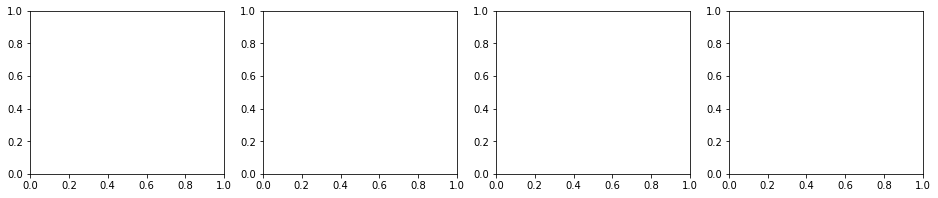

In [25]:
display_pca_data(n_components, decomp, BES_std, y=Sov)

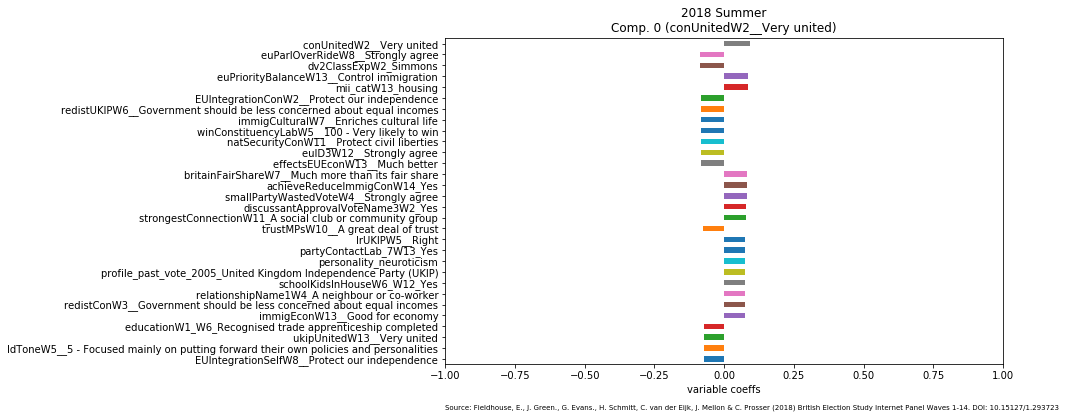

In [26]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_sov.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [27]:
focal_variable = "euMIISmallW8"
pattern = "euMIISmall|EUMIICategory"
target = BES_Panel[focal_variable]
n_components = len( BES_Panel[focal_variable].cat.categories )
n_components = 7
optional_mask = (BES_Panel["profile_eurefvote"]=="Leave the EU") & (BES_Panel["country"]=="England")
sorted_categories = list(BES_Panel[focal_variable][optional_mask].value_counts().index)[0:n_components]
drop_list = [x for x in BES_reduced.columns if re.match(pattern,x)]
print("Dropping: ")
print(drop_list)
train = BES_reduced.drop(drop_list,axis=1)
mask = target.notnull() & target.apply(lambda x: x in sorted_categories) & optional_mask
#        'Liberal Democrats'])
target = target[mask]
train = train[mask]
print("Looking at categories: ")
print(sorted_categories)

Dropping: 
['EUMIICategoryW7_immigration', 'EUMIICategoryW7_sovereignty', 'EUMIICategoryW7_economy general', 'EUMIICategoryW7_general concerns', 'EUMIICategoryW7_truth', 'EUMIICategoryW7_democratic deficit', 'EUMIICategoryW7_EU identity/cosmopolitan', 'EUMIICategoryW7_trade', 'EUMIICategoryW7_other', 'EUMIICategoryW7_security', 'EUMIICategoryW7_fiscal', 'EUMIICategoryW7_unemployment', 'EUMIICategoryW7_economic stability', 'EUMIICategoryW7_stability in general', 'EUMIICategoryW7_human rights', 'EUMIICategoryW7_freedom of movement', 'EUMIICategoryW7_worker rights', 'EUMIICategoryW7_british greatness', 'EUMIICategoryW7_partisan-neg', 'EUMIICategoryW7_family', 'EUMIICategoryW7_uncertainty', 'EUMIICategoryW7_international cooperation', 'EUMIICategoryW7_equality', 'EUMIICategoryW7_peace', 'EUMIICategoryW7_EU reform', 'EUMIICategoryW7_economy personal', 'EUMIICategoryW7_scotland', 'EUMIICategoryW7_living standards', 'EUMIICategoryW7_British identity', 'EUMIICategoryW7_british influence in the

(5568, 4990)

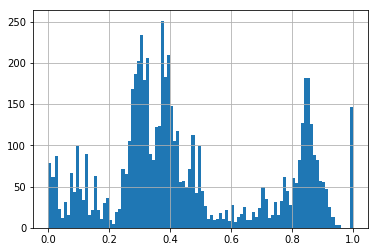

In [28]:
train = drop_zero_var(train)
# drops = [x for x in BES_reduced_with_na if re.match("small_mii_cat|ns_secW|age|miilabel",x)]
# df = df.drop(drops, axis=1, errors ='ignore')
# train = df
missing_vals = BES_reduced_with_na[ intersection(train.columns , BES_reduced_with_na.columns) ][mask].isnull()
missing_vals = (missing_vals.sum()/missing_vals.shape[0]).sort_values()
missing_vals.hist(bins=100);

drop_vars = list(missing_vals[missing_vals>.5].index)
drop_vars
train.drop(drop_vars,axis=1,inplace=True)
train.shape

In [29]:
target = target.apply(lambda x: x if x in ['Immigration', 'Sovereignty/EU bureaucracy'] else "Other")

In [30]:
Treatment = "AllLeaverTribes"  + dataset_name
output_subfolder = create_subdir(BES_output_folder,Treatment)
output_subfolder

'../BES_analysis_output/\\AllLeaverTribesW14_comb\\'

In [33]:
# normalise data (subtract out the mean, divide through by standard deviation)
BES_std = standard_scale(train)

n_components = BES_std.shape[1]
n_components = len(amalgamated_euMIISmall.cat.categories)
n_components = 2
# decomp = LinearDiscriminantAnalysis() ## ~10s ,n_components=30 -> 1.5 hrs
decomp = LinearDiscriminantAnalysis(solver="eigen",shrinkage = 'auto') ## ~10s ,n_components=30 -> 1.5 hrs
decomp_method = str(decomp).split("(")[0]

In [34]:
%%time
X_r = decomp.fit_transform(BES_std, target)
n_components = X_r.shape[1]
BES_decomp = pd.DataFrame(   X_r,
                             columns = range(0,n_components),
                             index   = BES_std.index)

load_suff = "LinearDiscriminantAnalysis"
save = True # False => Load
subdir = save_load_decomp(decomp, BES_decomp, BES_std, load_suff, save)
print("Score: ", decomp.score(BES_std, target))

Score:  0.8848778735632183
Wall time: 2min 1s


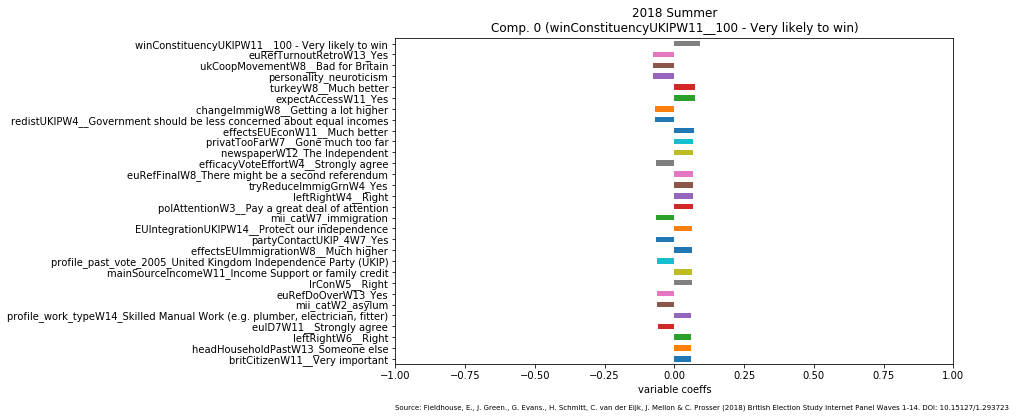

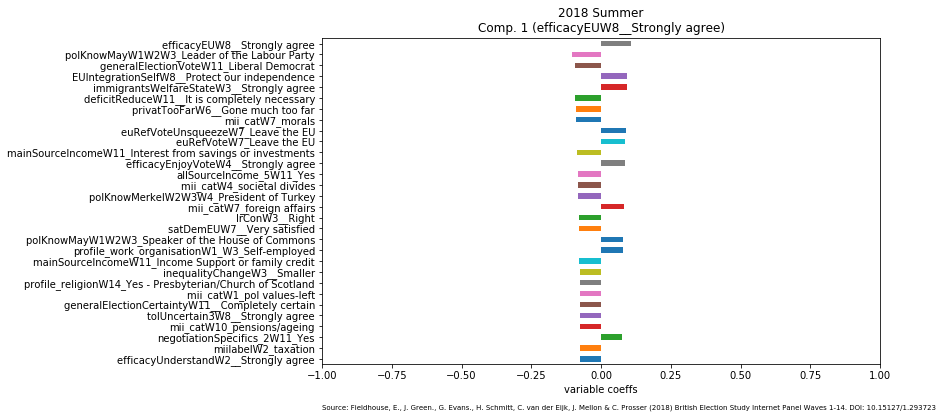

In [35]:
(BES_decomp, comp_labels, comp_dict) = display_components(n_components, decomp,
                                                          BES_std.columns, BES_decomp, manifest, 
                                                          save_folder = subdir,  
                                                          show_first_x_comps= 4, show_histogram = False)

In [40]:
x_axis = 0
y_axis = 1

xlim, ylim = get_decomp_lims(x_axis, y_axis, decomp, decomp_method, BES_decomp)

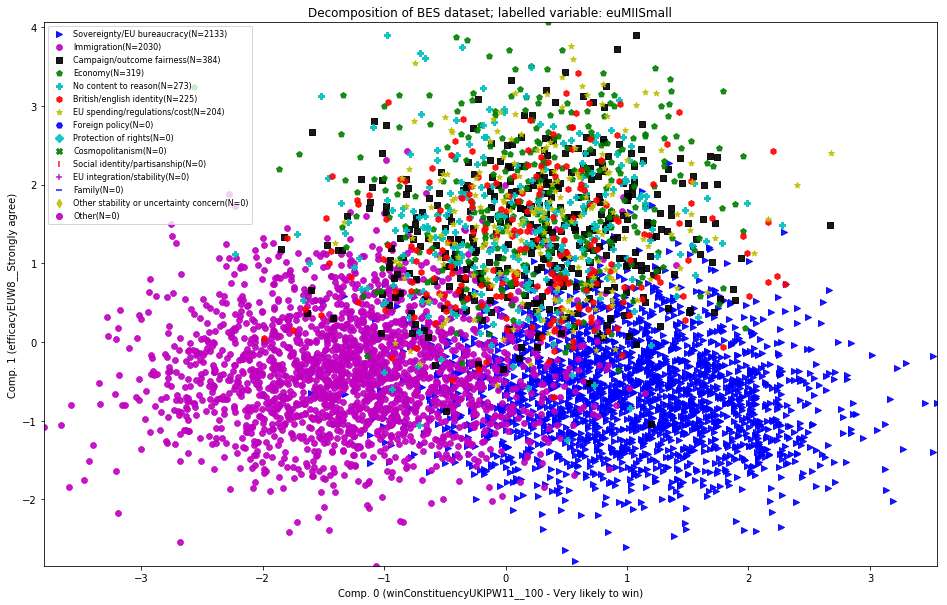

Wall time: 1.6 s


In [42]:
%%time

graph_type = "non_ordinal_scatter/"
folder = create_subdir(output_subfolder, graph_type)


dummy_list = ['euMIISmall']
df = pd.get_dummies(amalgamated_euMIISmall, prefix="euMIISmall")[mask]

make_ordinal_scatter(df, dummy_list)

In [ ]:
[x for x in BES_Panel.columns if "hope" in x]

In [107]:
ct = pd.crosstab( BES_Panel["profile_eurefvote"], BES_Panel["profile_house_tenure"],
             values= BES_Panel[ num_to_weight[8] ], aggfunc=sum, normalize='columns')*100

In [108]:
sorted_labels = list(BES_Panel["profile_house_tenure"].value_counts().index)

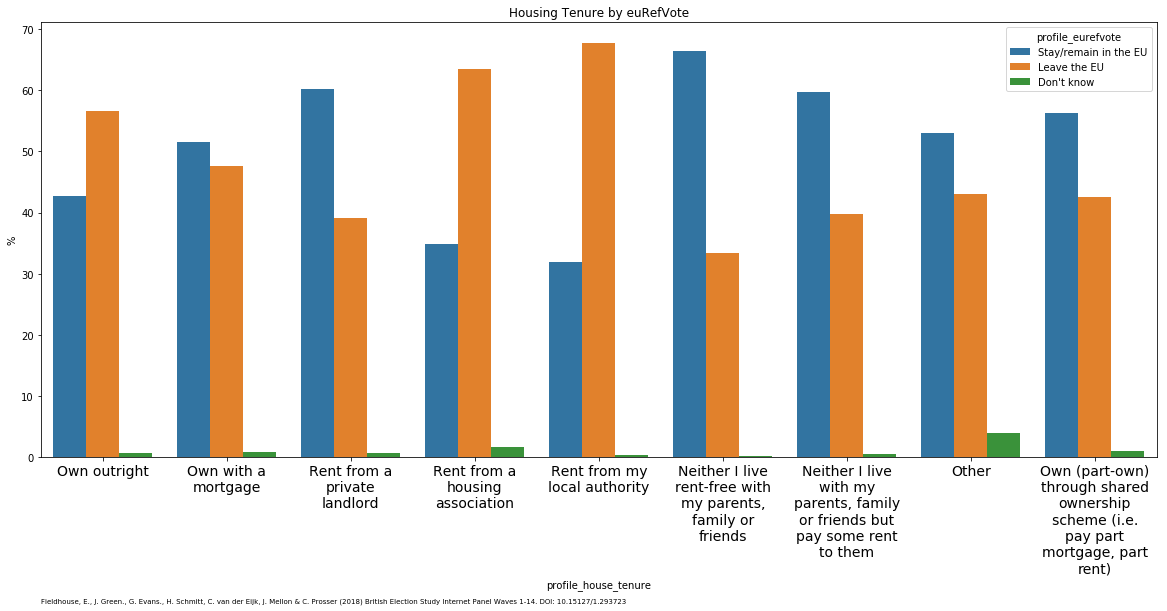

In [109]:

import textwrap 
  
wrapper = textwrap.TextWrapper(width=15) 

stacked = ct.stack().reset_index().rename(columns={0:'%'})
fig = plt.figure(figsize=(20, 8))
ax = fig.subplots()

sns.barplot(x=stacked["profile_house_tenure"],
            y=stacked['%'],
            hue=stacked["profile_eurefvote"],
            ax=ax, order = sorted_labels);
# plt.xticks(rotation=90);
# ax = plt.gca()

# labels = stacked["profile_house_tenure"].cat.categories
title = "Housing Tenure by euRefVote"
plt.title(title)
ax.set_xticklabels([ wrapper.fill(text=x) for x in sorted_labels], rotation=0, fontsize=14);

ax.annotate(dataset_citation, (0,0), (0, -140),
                 xycoords='axes fraction', textcoords='offset points', va='top', fontsize = 7) ;           
fname = output_subfolder + title.replace(" ","_") + ".png"
fig.savefig( fname, bbox_inches='tight' )

In [111]:
def make_categorical_density_plot():
    fig, axes = plt.subplots(1, 1, figsize=(16,10))    
    sov_vars = (BES_reduced_with_na[[x for x in BES_reduced_with_na.columns if re.match(cat_var+"_", x)]][mask&amalg_imm.notnull()]==1)\
                .sum().sort_values(ascending=False)
    sov_vars = sov_vars.drop(sov_vars[sov_vars<min_sample].index)
    if len(sov_vars.index)==0:
        return
    
    for sov in sov_vars.index:
#         if sov not in cat_col_mar_dict.keys(): # try to give mii consistent colour, marker pairs
#             cat_col_mar_dict[sov] = (next(colours),next(markers))        
        sov_imm = amalg_imm[(BES_reduced_with_na[sov]==1.0)&mask]
        base_label = sov.split("_")[-1]

        (col, mar) = get_cat_col_mar(base_label, BES_small_data_files)
        label = base_label +"(N="+str(sov_vars.loc[sov])+")"
        sns.kdeplot(sov_imm,
                    label=label,
                    bw=.5,
                    ax = axes,
                    color = col,
                    marker = mar,
                    alpha = .75);

    sns.kdeplot(amalg_imm,
                label="Everyone-Leaver/Remainer/Neither"+"(N="+str(amalg_imm.notnull().sum())+")",
                bw=.5,
                ax = axes,
                color = 'k',
                linewidth=7.0,
                alpha = .75);       

    # axes.set_ylim([0,.6])
    axes.set_xlim([0,len(cross_var_labels)-1]);
    axes.set_xticks(list(range(0,len(cross_var_labels))))
    axes.set_xticklabels(cross_var_labels);
    axes.set_xlabel(cross_var_text);
    plt.legend(loc='upper right',title=cat_var);
    wave_descr = BES_file_manifest[ (BES_file_manifest["Only_or_Combined"]=="Only")\
                     & (BES_file_manifest["Wave No"]==wave) ]["Friendlier_Description"].values[0]    
    plt.title(question+"\n"\
             +wave_descr\
             +"\n"+subtitle);

    fname = cat_var + "_" + subtitle +"_by_"+cross_var 
    plt.savefig( output_subfolder + clean_filename(fname, char_limit=50) + ".png", bbox_inches='tight' )
#     plt.close()

In [110]:
Treatment = "Sovereignty_vs_Immigration"
base_folder = create_subdir(BES_output_folder, Treatment)

sub_treatment = "category_by_immigself"
output_subfolder = create_subdir(base_folder, sub_treatment)

Amalgamating variables: 
{7: 'ukCoopMovementW7__Bad for Britain', 8: 'ukCoopMovementW8__Bad for Britain', 10: 'ukCoopMovementW10__Bad for Britain'}
euMIISmallW7 Leavers


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


euMIISmallW7 Remainers
euMIISmallW7 Don't know
euMIISmallW8 Leavers
euMIISmallW8 Remainers
euMIISmallW8 Don't know


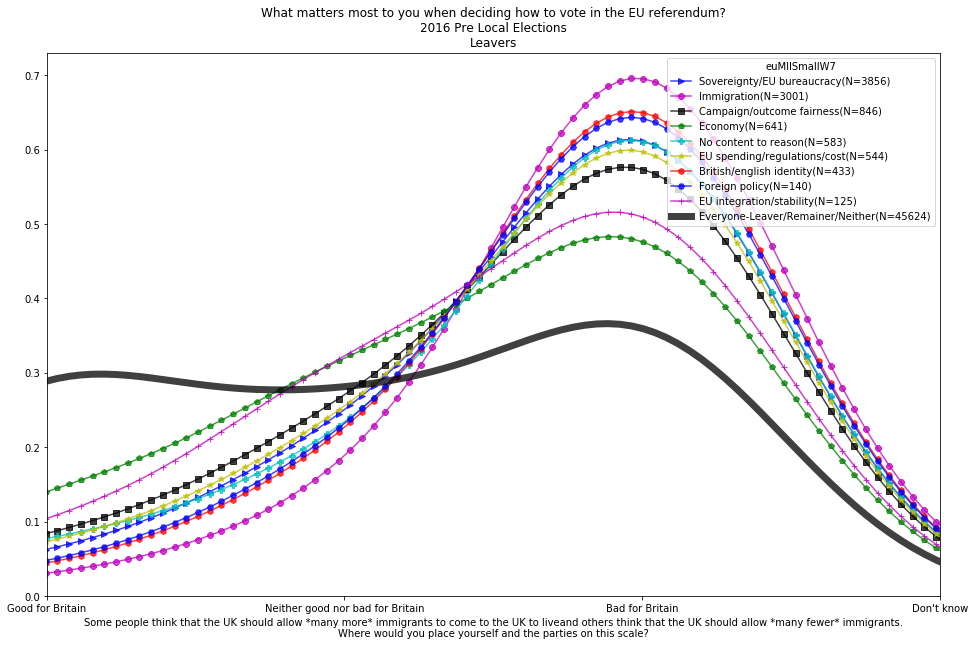

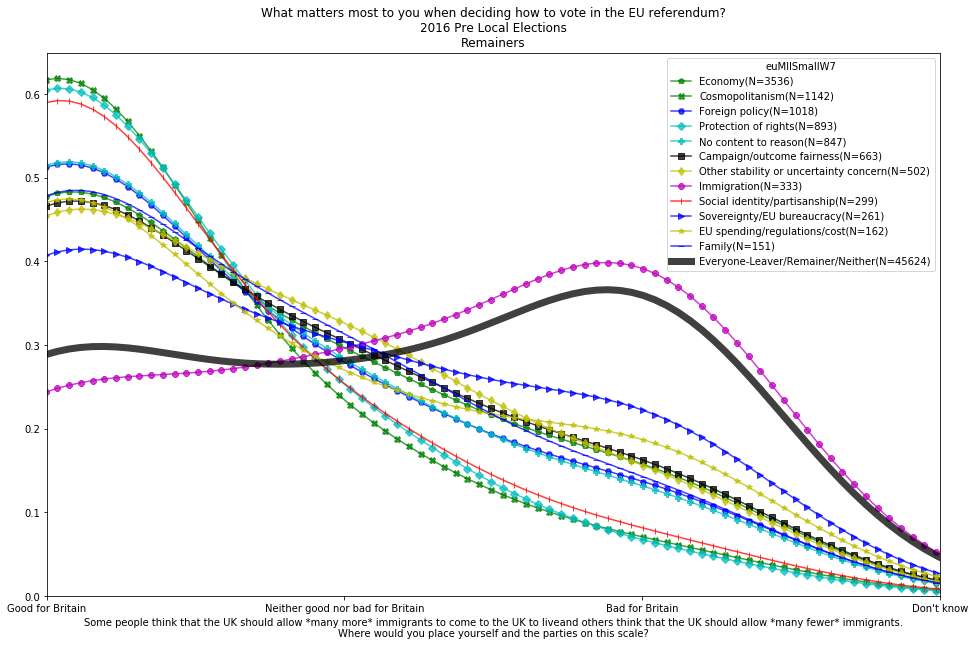

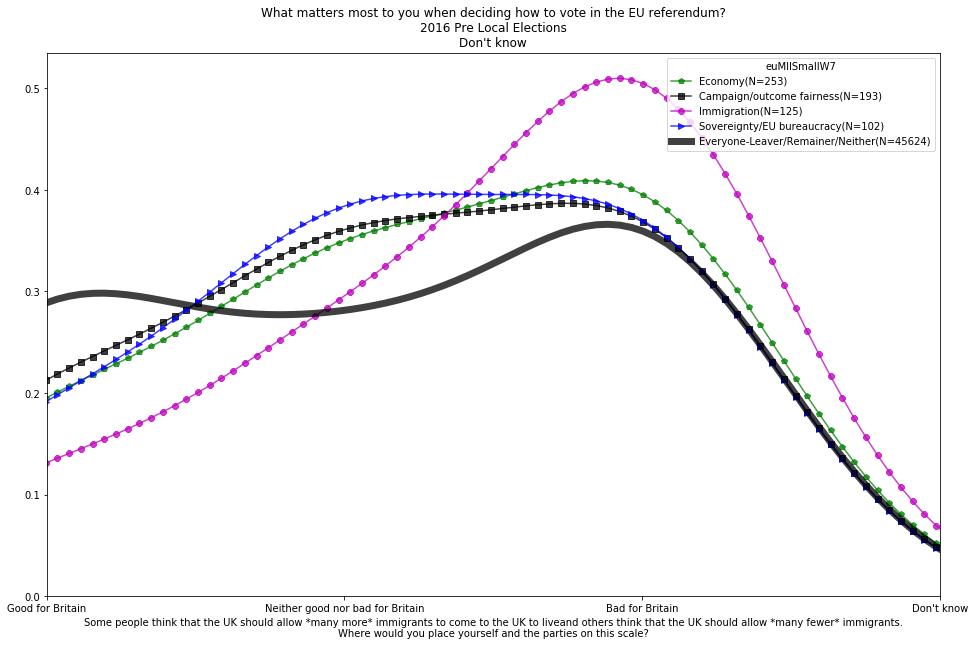

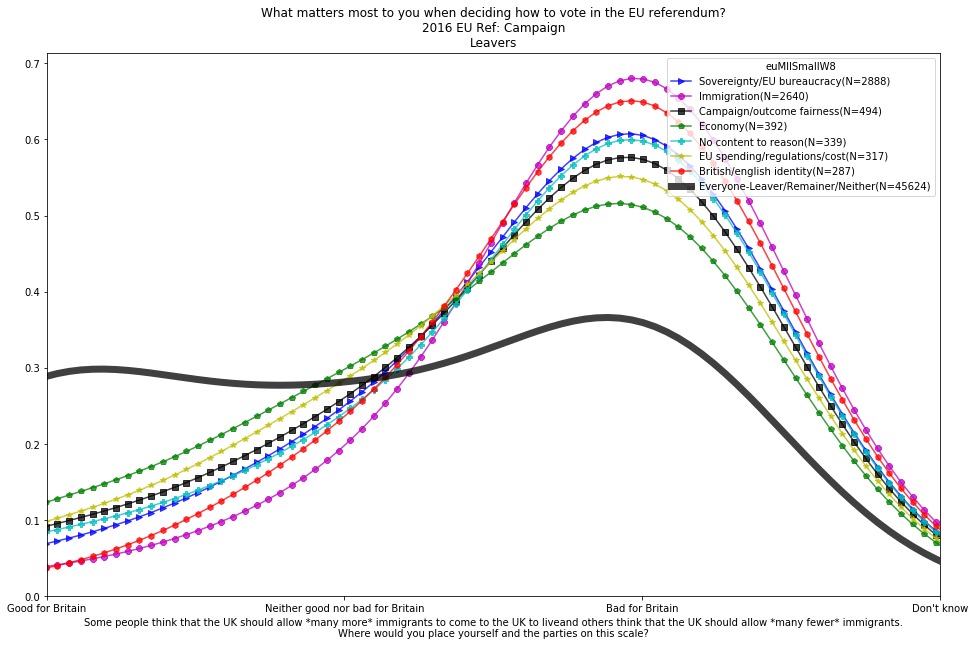

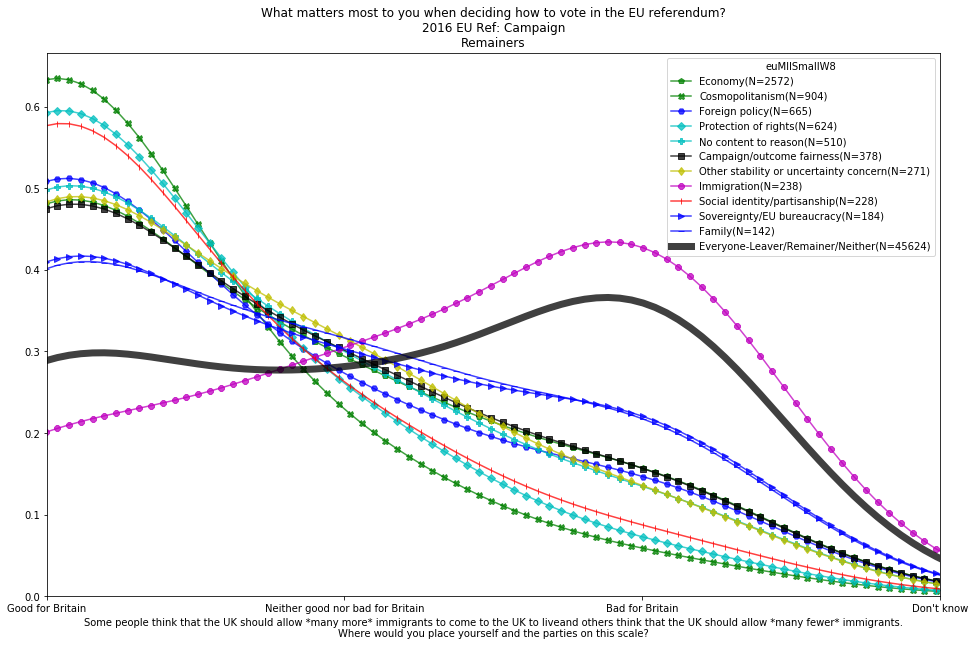

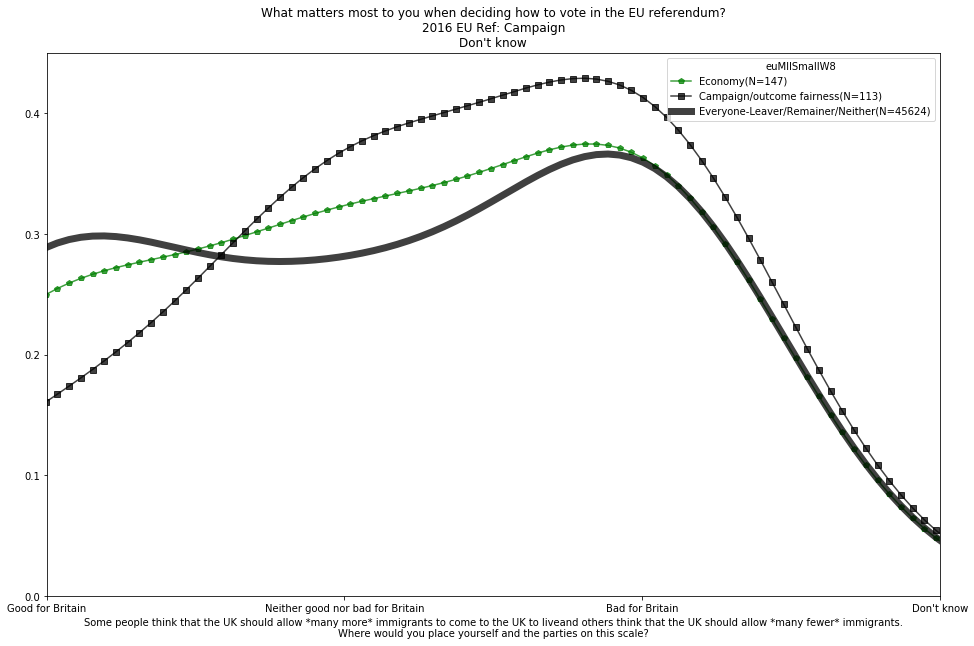

In [112]:
cross_var = "ukCoopMovement"
cross_var_text = "Some people think that the UK should allow *many more* immigrants to come to the UK to live"+\
                    "and others think that the UK should allow *many fewer* immigrants."+\
                    "\nWhere would you place yourself and the parties on this scale?"
cross_var_example = BES_Panel[[x for x in BES_Panel.columns if re.match(cross_var, x)][0]]
if cross_var_example.dtype.name == 'category':
    cross_var_labels = cross_var_example.cat.categories
    amalg_imm = amalgamate_waves(BES_reduced_with_na,cross_var,forward_fill=False)
else:
    cross_var_labels = list( cross_var_example.value_counts().sort_index().index )
    amalg_imm = BES_reduced_with_na[cross_var]
    
masks = {"Leavers":"Leave the EU","Remainers":"Stay/remain in the EU","Don't know":"Don't know"}
# cat_vars = ["euMIISmallW7","euMIISmallW8","EUMIICategoryW7","EUMIICategoryW8"]
# cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("bestOnMII|miilabel|small_mii_cat|mii_cat|LRAL_mii_cat|EUMIICategory|euMIISmall",x) ])))
cat_vars = sorted(list(set(["_".join(x.split("_")[:-1]) for x in BES_reduced_with_na.columns if re.match("euMIISmall",x) ])))
min_sample = 100

for cat_var in cat_vars:
    question = "What matters most to you when deciding how to vote in the EU referendum?"
    wave = int(re.search("W(\d+)",cat_var).groups()[0])
    for subtitle,mask_cat in masks.items():
        print(cat_var,subtitle)
        if ("euRefVoteW"+str(wave)) not in BES_Panel.columns:
            mask = (BES_Panel["profile_eurefvote"]==mask_cat)
        else:
            mask = (BES_Panel["euRefVoteW"+str(wave)]==mask_cat)

        make_categorical_density_plot()
